# Mobile Manipulator Path Planning & Benchmarking

**Course:** Roboterprogrammierung (Winter 25/26)  
**Institution:** Hochschule Karlsruhe - University of Applied Sciences (HKA)  

---

## 📋 Overview

This notebook provides a comprehensive framework for evaluating motion planning algorithms on a **5-DOF planar mobile manipulator**. The system combines a mobile base (3-DOF: x, y, θ) with a 2-DOF articulated arm, and supports manipulation tasks via Pick & Place operations.

### Key Capabilities

- **Collision Detection Engine**: Custom implementation handling base-obstacle, arm-obstacle, and self-collision detection
- **Motion Planning Algorithms**: Sampling-based planners (LazyPRM, VisibilityPRM) with support for multi-goal sequences
- **Manipulation Support**: Pick & Place operations with dynamic object attachment/detachment
- **Automated Benchmarking**: Batch evaluation framework for statistical performance analysis
- **Interactive Visualization**: Real-time robot configuration inspection and trajectory playback

---

## 🔄 Workflow

1. **Setup** → Import libraries and configure environment
2. **Planning** → Execute path planning algorithms on benchmark scenarios
3. **Visualization** → Display single-run results and animated trajectories
4. **Benchmarking** → Run multiple iterations for statistical evaluation
5. **Analysis** → Visualize and interpret performance metrics

---

## 1️⃣ Environment Setup

### Imports & Auto-reload

Load required libraries and configure the development environment. Auto-reload is enabled to reflect source code changes without kernel restart.

In [1]:
"""
Environment configuration for Mobile Manipulator path planning notebook.

Sets up auto-reload, imports all necessary dependencies, and configures
Python path for module imports from the project structure.
"""

# --- Auto-reload modules when source code changes ---
# CRITICAL: Allows hot-reloading of src/ modules without kernel restart
%load_ext autoreload
%autoreload 2

# --- Standard Libraries ---
import copy
import os
import sys

# --- Data & Visualization ---
import matplotlib.animation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import networkx as nx
import numpy as np
import pandas as pd

# --- Interactive UI ---
from ipywidgets import interact, FloatSlider, Dropdown, Layout, Checkbox, Button, VBox, HBox, Output
from IPython.display import HTML, display, clear_output

# --- Configure Python Path ---
# Ensure proper module resolution for the project structure
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

planners_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src', 'planners'))
if planners_path not in sys.path:
    sys.path.append(planners_path)

print(f"✓ Project root added: {project_root}")
print(f"✓ Planners path added: {planners_path}")

# --- Import Test Suite & Configuration ---
from IPTestSuite import *

# --- Import Core Components ---
from IPAnimator import IPAnimator
from IPPerfMonitor import IPPerfMonitor
from IPResultCollection import ResultCollection
from IPBatchEvaluator import BatchEvaluator
from IPMultiGoalPlannerRunner import MultiGoalPlannerRunner

# --- Import Visualizers ---
from IPBenchmarkPlotter import BenchmarkPlotter
from IPBatchPlotter import BatchPlotter
from IPSingleRunPlotter import SingleRunPlotter

# --- Import Motion Planning Algorithms ---
from IPVisibilityPRM import VisPRM as VisPRM
from IPVisibilityPRM_multiGoal import VisPRM as VisPRM_multiGoal
from IPVISVisibilityPRM import visibilityPRMVisualize
from IPLazyPRM import LazyPRM as LazyPRM
from IPLazyPRM_multiGoal import LazyPRM as LazyPRM_multiGoal
from IPVISLazyPRM import lazyPRMVisualize

# --- Output Configuration ---
savePlots = False  # Set to True to save plot images
folderPath2save = "/Users/glaserpaul/Documents/010_HKA_RKIM/Mobiler_Manipulator/runs/20260119_SelfCheck"

print("✓ All modules imported successfully")

✓ Project root added: /Users/glaserpaul/Documents/010_HKA_RKIM/Mobiler_Manipulator
✓ Planners path added: /Users/glaserpaul/Documents/010_HKA_RKIM/Mobiler_Manipulator/src/planners
TestSuite geladen. Benchmarks für Pick & Place konfiguriert.
✓ All modules imported successfully


## 2️⃣ Planner Configuration

### Creating Planner Factory

Configure and instantiate motion planning algorithms with problem-specific parameters. Each planner is defined with:
- **Class reference**: The algorithm implementation
- **Configuration dictionary**: Algorithm-specific hyperparameters
- **Visualization function**: For rendering planning results

#### Configuration Notes

- **5D Configuration Space**: [x, y, θ, q1, q2] requires careful parameter tuning
- **VisibilityPRM**: High sampling rate for finding critical narrow-passage configurations
- **LazyPRM**: Dense roadmap with frequent updates when no solution found

In [2]:
"""
Define and configure motion planning algorithms for the 5-DOF mobile manipulator.

Each planner is configured with parameters optimized for the 5-dimensional
configuration space characteristics of this problem.
"""

plannerFactory = dict()

# --- VisibilityPRM Configuration ---
# Strategy: Guard-based node selection. Discards "visible" nodes that are well-connected.
# Challenge in 5D: Risk of discarding critical bottleneck configurations.
# Solution: Very high sampling rate to ensure sufficient guard discovery.
visbilityConfig = dict()
visbilityConfig["ntry"] = 500  # Sampling attempts (recommended 400-800 for 5D)
plannerFactory["visibilityPRM"] = [VisPRM, visbilityConfig, visibilityPRMVisualize]

# --- LazyPRM Configuration ---
# Strategy: Aggressive exploration ("shoot first, ask questions later").
# Floods configuration space with nodes, then validates edge feasibility.
# Advantage: Robust in high-dimensional spaces.
lazyConfig = dict()
lazyConfig["initialRoadmapSize"] = 500   # Initial node count for good coverage
lazyConfig["updateRoadmapSize"] = 200    # Additional nodes per replanning iteration
lazyConfig["kNearest"] = 12              # 5D requires more neighbors than 2D (typical: 5-6)
lazyConfig["maxIterations"] = 15         # Iterations before declaring failure
plannerFactory["lazyPRM"] = [LazyPRM, lazyConfig, lazyPRMVisualize]

# --- Initialization Report ---
print("=" * 60)
print("PLANNER FACTORY INITIALIZED")
print("=" * 60)
print("\nConfigured Planners:")
plannerNames = []
for planner_name in plannerFactory:
    plannerNames.append(planner_name)
    config = plannerFactory[planner_name][1]
    print(f"\n  • {planner_name.upper()}")
    for key, value in config.items():
        print(f"    - {key}: {value}")

print("\nAvailable Benchmarks:")
benchNames = []
for benchmark in benchList:
    benchNames.append(benchmark.name)
    print(f"  • {benchmark.name}: {benchmark.description}")

print("=" * 60)

PLANNER FACTORY INITIALIZED

Configured Planners:

  • VISIBILITYPRM
    - ntry: 500

  • LAZYPRM
    - initialRoadmapSize: 500
    - updateRoadmapSize: 200
    - kNearest: 12
    - maxIterations: 15

Available Benchmarks:
  • Empty World: Freier Raum. Testet, ob der Planer eine direkte Linie findet.
  • The Wall: Eine Wand mit einer Lücke. Der Roboter muss durchfahren.
  • Narrow Passage: Narrow Passage. Erfordert präzise Basis-Bewegung.
  • Forest: Clutter. Roboter muss slalomen, Arm darf nicht ausschlagen.
  • Shelf Reach: Reach Task. Die Basis kann das Ziel nicht erreichen, der Arm muss rüberreichen.


## 3️⃣ Interactive Robot Visualization

### Configuration Space Explorer

Manually inspect robot configurations across different scenarios. Use the sliders to:
- **Scenario**: Select benchmark environment with obstacles
- **Position (x, y)**: Mobile base location
- **Base Theta**: Mobile base orientation
- **Joints (q1, q2)**: Arm joint angles
- **Attach Object**: Enable/disable gripper object for Pick & Place visualization

The visualization displays:
- **Blue**: Current robot configuration
- **Green (dashed)**: Start configuration
- **Purple (dashed)**: Intermediate goal configurations
- **Red (dashed)**: Final goal configuration
- **Gray**: Static obstacles
- **Status indicator**: Real-time collision feedback

In [ ]:
"""
Interactive configuration space explorer for the mobile manipulator.

Allows manual robot configuration control and real-time collision checking
across different benchmark scenarios.
"""

# --- Setup ---
bench_names = [b.name for b in benchList]

def interact_bench_suite(bench_name, x, y, theta, q1, q2, attach_obj):
    """
    Interactive robot configuration visualization with collision feedback.
    
    Displays the robot at a user-specified configuration within a selected benchmark
    scenario. Includes visual indicators for start position, goal positions, and
    obstacles. Provides real-time collision detection feedback.
    
    Args:
        bench_name (str): Name of the benchmark scenario to visualize
        x (float): Mobile base x-position (meters)
        y (float): Mobile base y-position (meters)
        theta (float): Mobile base orientation (radians)
        q1 (float): First joint angle (radians)
        q2 (float): Second joint angle (radians)
        attach_obj (bool): Whether to attach object to gripper for visualization
    """
    plt.close('all')

    # 1. Retrieve benchmark and collision checker
    current_bench = next(b for b in benchList if b.name == bench_name)
    cc = current_bench.collisionChecker

    # 2. Manage object attachment based on user input
    if attach_obj:
        obj_shape = cc.get_object_shape()
        cc.attach_object(obj_shape)
    else:
        cc.detach_object()

    # 3. Create and validate configuration
    config = np.array([x, y, theta, q1, q2], dtype=float)

    # 4. Collision check
    try:
        if hasattr(cc, 'pointInCollision'):
            is_collision = cc.pointInCollision(config)
    except Exception as e:
        print(f"Collision Check Error: {e}")
        is_collision = True

    # 5. Visualization
    try:
        fig, ax = plt.subplots(figsize=(5, 5))
        
        # Draw obstacles and current robot configuration
        cc.drawObstacles(ax)
        cc.drawRobot(config, ax, alpha=1)
        
        # Overlay start configuration (green dashed)
        start_conf = np.array(current_bench.startList[0])
        geo_start = cc.get_robot_geometry(start_conf)
        ax.plot(*geo_start['base'].exterior.xy, color='green', linestyle='--', 
                alpha=0.5, label='Start Base')
        
        # Overlay goal configurations (purple for intermediate, red for final)
        for goals in current_bench.goalList:
            goal_raw = goals[0]
            goal_conf = np.array(goal_raw)
            
            # Determine goal color (last goal is final destination)
            last_goal_raw = current_bench.goalList[-1]
            last_goal_coords = last_goal_raw[0] if isinstance(last_goal_raw, (tuple, list)) and len(last_goal_raw) == 2 and isinstance(last_goal_raw[1], str) else last_goal_raw
            
            if np.allclose(goal_conf, last_goal_coords):
                goal_color = 'red'
            else:
                goal_color = 'purple'
                
            geo_goal = cc.get_robot_geometry(goal_conf)
            ax.plot(*geo_goal['base'].exterior.xy, color=goal_color, linestyle='--', 
                    alpha=0.5, label='Goal Base')

        # --- Plot Configuration ---
        ax.set_xlim(LIMITS[0])
        ax.set_ylim(LIMITS[1])
        ax.set_aspect('equal')
        ax.axis('on')
        
        # Grid setup
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
        ax.grid(which='major', alpha=0.5, color='gray', linestyle='-')
        ax.grid(which='minor', alpha=0.2, color='gray', linestyle='--')
        ax.tick_params(axis='both', which='both', labelbottom=True, labelleft=True)

        ax.legend(loc='upper left')

        # Status display
        status_color = 'red' if is_collision else 'green'
        status_text = "⚠ COLLISION!" if is_collision else "✓ COLLISION-FREE"
        attach_text = " [HOLDING OBJECT]" if attach_obj else ""
        
        ax.set_title(f"Scenario: {bench_name}{attach_text}\nStatus: {status_text} | Self-Collision Check: {SELF_CHECK}", 
                     color=status_color, fontweight='bold', fontsize=12)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Visualization Error: {e}")
        import traceback
        traceback.print_exc()

# --- Create Interactive Widgets ---
point_to_show = START[0]
interact(interact_bench_suite, 
         bench_name=Dropdown(options=bench_names, description='Scenario:'),
         attach_obj=Checkbox(value=False, description='Attach Object'),
         x=FloatSlider(min=LIMITS[0][0], max=LIMITS[0][1], step=0.1, value=point_to_show[0]),
         y=FloatSlider(min=LIMITS[1][0], max=LIMITS[1][1], step=0.1, value=point_to_show[1]),
         theta=FloatSlider(min=LIMITS[2][0], max=LIMITS[2][1], step=0.01, value=point_to_show[2], description='Base Theta'),
         q1=FloatSlider(min=LIMITS[3][0], max=LIMITS[3][1], step=0.01, value=point_to_show[3], description='Joint 1'),
         q2=FloatSlider(min=LIMITS[4][0], max=LIMITS[4][1], step=0.01, value=point_to_show[4], description='Joint 2')
        );

interactive(children=(Dropdown(description='Scenario:', options=('Empty World', 'The Wall', 'Narrow Passage', …

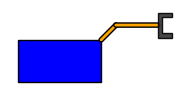

In [4]:
"""Static visualization of the robot at the start configuration."""

cc = benchList[0].collisionChecker

fig, ax = plt.subplots(figsize=(2, 2))

# Visualize obstacles and robot
cc.drawObstacles(ax)
cc.drawRobot(START[0], ax, alpha=1)

ax.set_aspect('equal')
ax.axis('off')

plt.tight_layout()
plt.show()

## 4️⃣ Single-Run Planning & Visualization

### Execute Planning Benchmarks

Run the configured planners on each benchmark scenario. For each planner-benchmark pair:
1. Fresh planner instance is created (stateless for reproducibility)
2. Multi-goal planning executed via `MultiGoalPlannerRunner`
3. Results collected with trajectory and performance data
4. Roadmap and planning statistics preserved for visualization

### Results Interpretation

- **Success**: All goal segments planned successfully
- **Partial Path**: Planning failed at a specific goal segment (marked with action)
- **Exception**: Algorithm crashed or invalid input detected

In [5]:
"""
Execute path planning benchmarks using configured planners and scenarios.

For each planner-benchmark combination:
- Instantiate fresh planner (ensures stateless execution)
- Execute multi-goal planning with Pick & Place support
- Collect trajectory, performance metrics, and planning statistics
- Handle partial paths and planning failures gracefully
"""

resultList = list()
plotList = []

for planner_name, producer in list(plannerFactory.items()):
    print("\n" + "=" * 70)
    print(f"EXECUTING: {planner_name.upper()}")
    print("=" * 70)
    
    for benchmark in benchList:
        print(f"\n  Benchmark: {benchmark.name}")
        
        # Instantiate fresh planner instance for this run
        planner = producer[0](benchmark.collisionChecker)
        config = producer[1]
        
        # Clear previous performance data
        IPPerfMonitor.clearData()
        
        try:
            # Execute multi-goal planning
            full_path, action_events, status = MultiGoalPlannerRunner.run_benchmark(planner, benchmark, config)
            
            # Collect results
            resultList.append(ResultCollection(
                plannerFactoryName=planner_name,
                planner=planner,
                benchmark=benchmark,
                solution=full_path,
                actions=action_events,
                status=status,
                perfDataFrame=IPPerfMonitor.dataFrame()
            ))

            # Status reporting
            if status['success']:
                print(f"    ✓ SUCCESS - Path found with {len(full_path)} nodes")
            else:
                print(f"    ⚠ PARTIAL - {status['fail_reason']}")
            
            plotList.append(1)
            
        except Exception as e:
            plotList.append(0)
            print(f"    ✗ ERROR - {str(e)}")

print("\n" + "=" * 70)
print(f"Planning Complete: {len(resultList)} successful runs, {plotList.count(0)} failures")
print("=" * 70)


EXECUTING: VISIBILITYPRM

  Benchmark: Empty World
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.
        [Action] PICK: Removed static object.
        [Action] PICK: Grasping.
        [Runner] Segment 1: PLACE with offset [0.0, -0.6]. Planning to Standoff.
        [Action] PLACE: Releasing.
        [Action] PLACE: Object becomes obstacle.
        [Runner] Segment 2: MOVE. Planning directly to target.
    ✓ SUCCESS - Path found with 33 nodes

  Benchmark: The Wall
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.
        [Action] PICK: Removed static object.
        [Action] PICK: Grasping.
        [Runner] Segment 1: PLACE with offset [0.0, -0.6]. Planning to Standoff.
        [Action] PLACE: Releasing.
        [Action] PLACE: Object becomes obstacle.
        [Runner] Segment 2: MOVE. Plann

## 5️⃣ Results Visualization

### Single-Run Planning Results

Generates comprehensive visualizations for each planned path including:
- **Roadmap visualization**: Shows sampled configurations and connections
- **Path overlay**: Highlights the solution path on the roadmap
- **Planning statistics**: Node count, edge count, path length metrics
- **Multi-goal sequences**: Visualizes all sequential goal achievement with Pick & Place

Generating single-run visualizations...


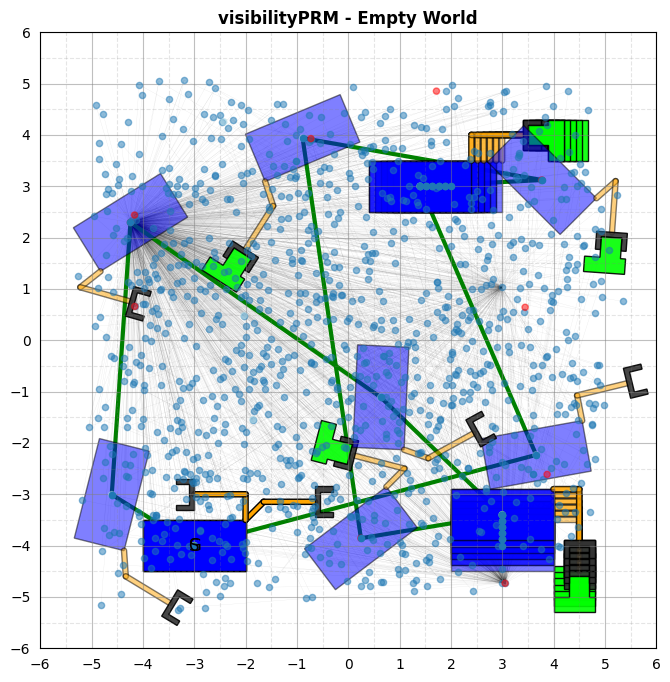

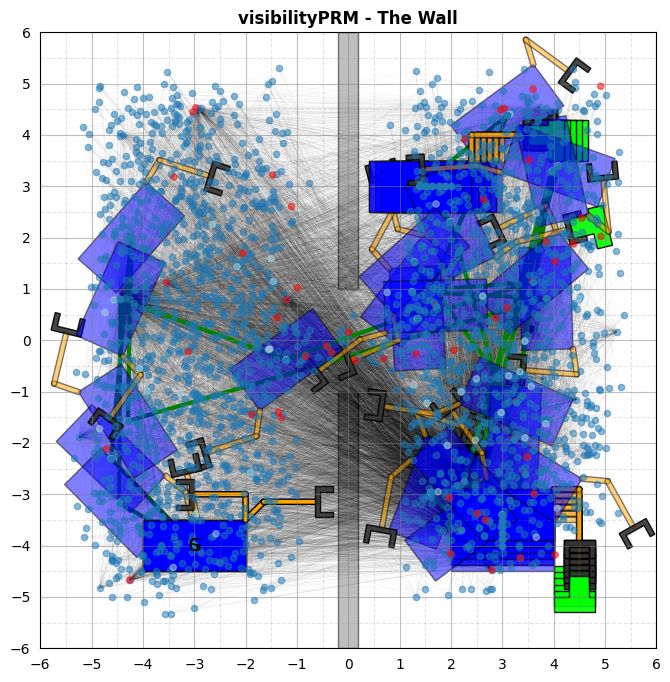

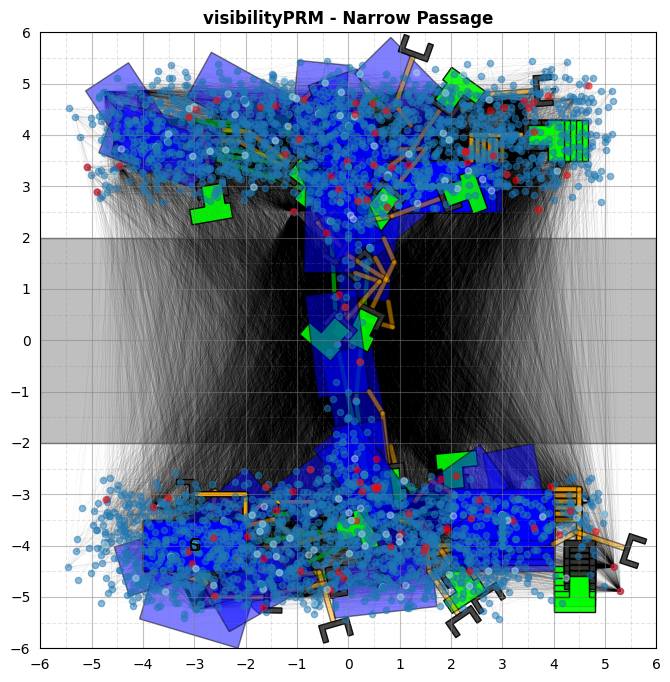

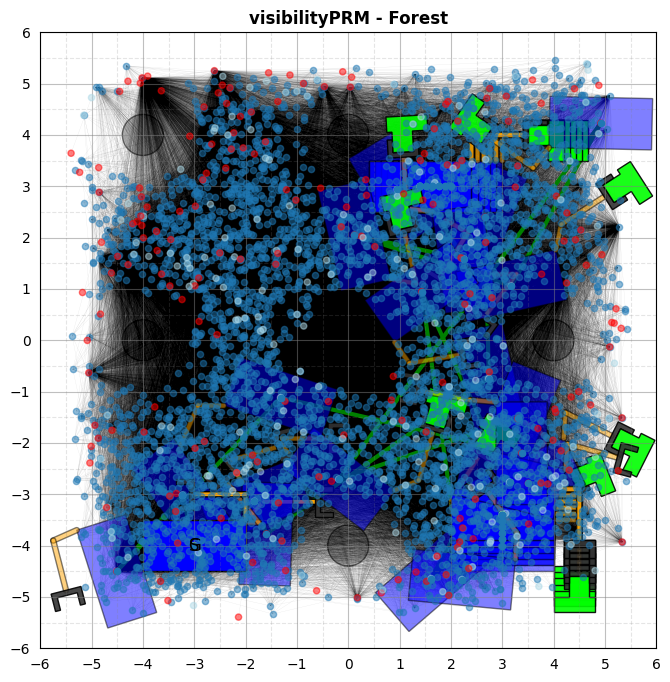

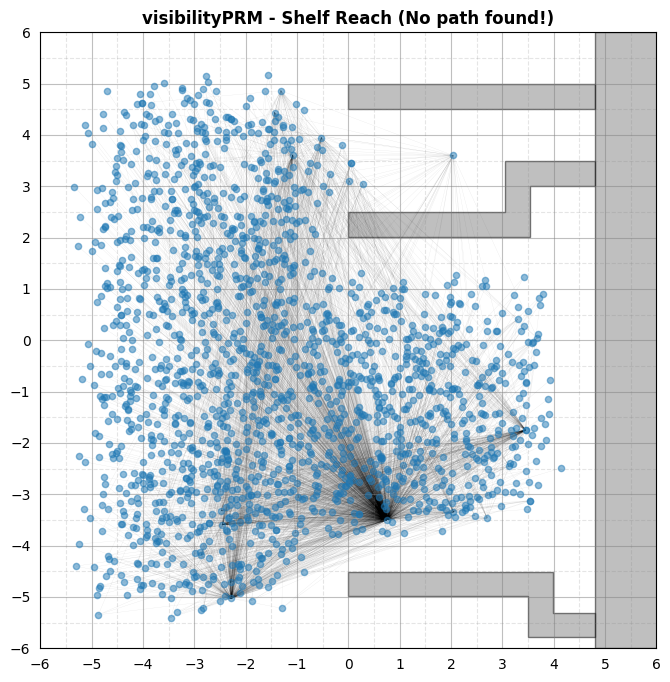

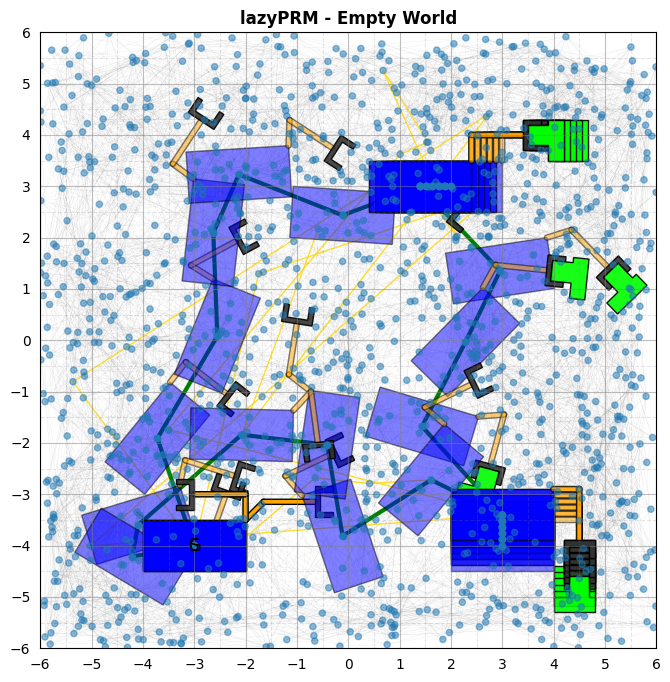

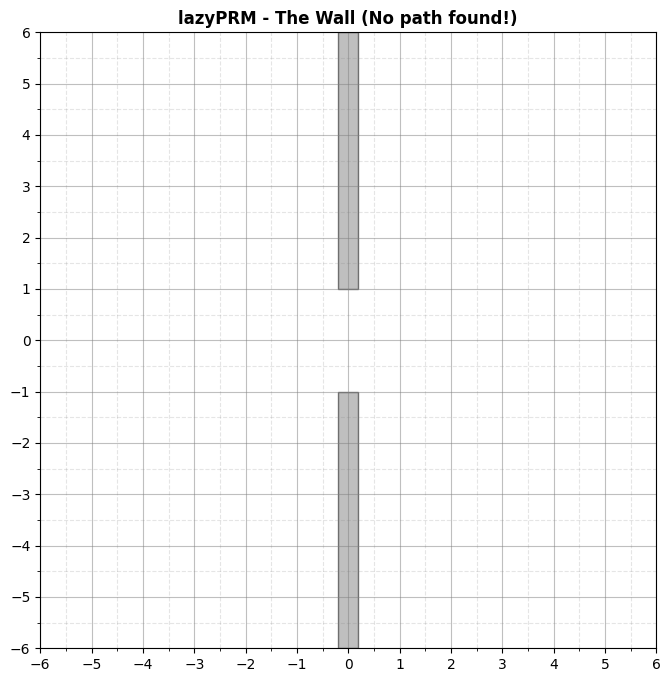

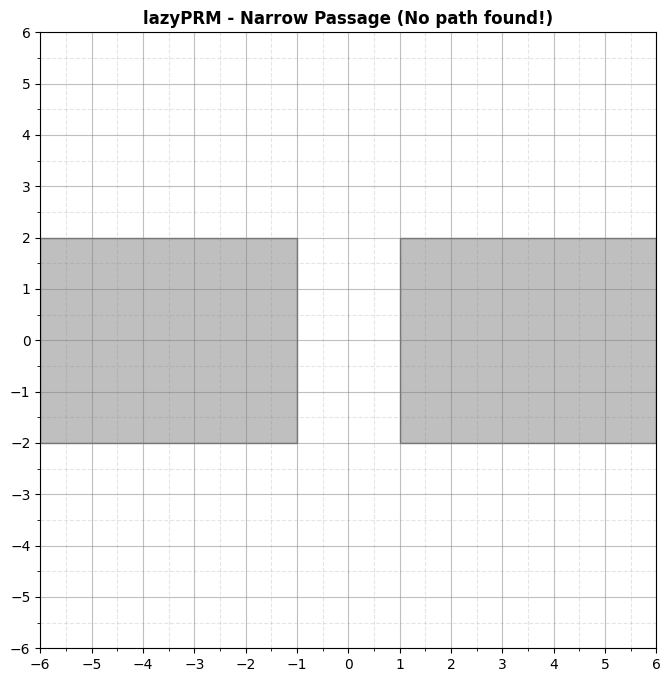

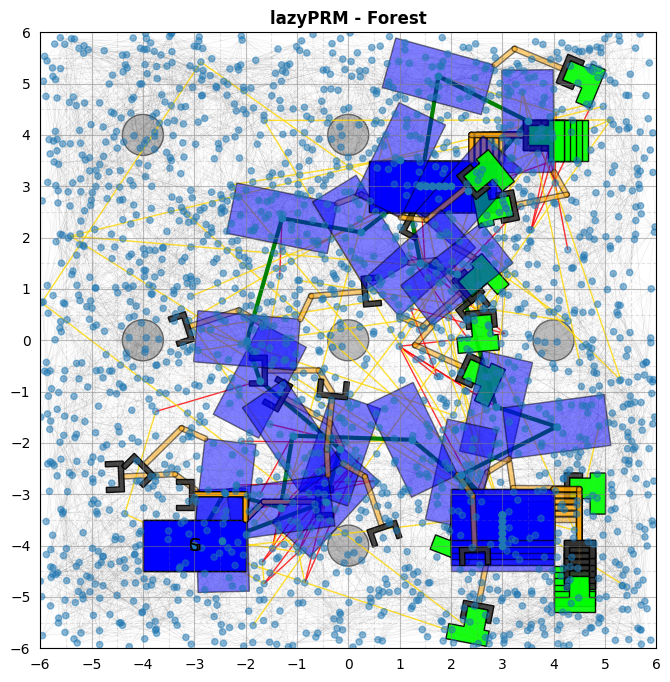

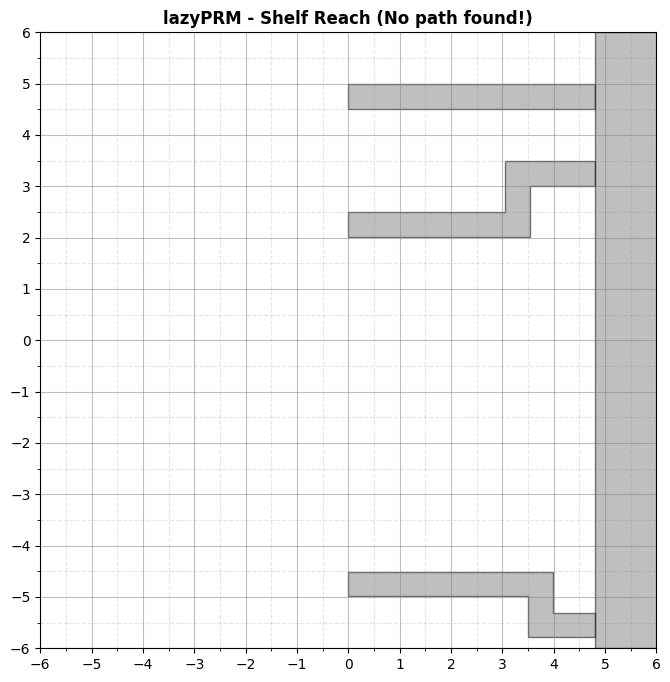

✓ Visualization complete


In [6]:
"""Visualize and optionally save single-run planning results."""

print("Generating single-run visualizations...")
SingleRunPlotter.visualize_and_save(
    resultList, 
    plotList, 
    plannerNames, 
    benchNames, 
    plannerFactory, 
    save_plots=savePlots,
    output_dir=folderPath2save
)
print("✓ Visualization complete")

## 6️⃣ Interactive Path Visualization

### Animated Trajectory Playback

Provides interactive controls to replay computed trajectories with real-time visualization:
- **Planner selection**: Choose algorithm to visualize
- **Scenario selection**: Choose benchmark scenario
- **Playback control**: Step through trajectory configurations
- **Animation speed**: Adjust playback rate
- **Configuration display**: Shows current pose and joint angles

In [7]:
"""Create and display interactive trajectory viewer for planned paths."""

try:
    anim_limits = LIMITS
except NameError:
    anim_limits = (-10, 25)

print("Initializing interactive trajectory viewer...")
ui = IPAnimator.create_interactive_viewer(plannerFactory, resultList, limits=anim_limits)
display(ui)
print("✓ Viewer ready")

Initializing interactive trajectory viewer...


✓ Viewer ready


## 7️⃣ Single-Run Performance Analysis

### Benchmark Comparison

Aggregates performance metrics from the single planning runs for comparison:
- **Success rate**: Percentage of successful plans per planner-benchmark pair
- **Path length**: Euclidean and node-count metrics
- **Algorithm performance**: Execution time and roadmap statistics
- **Comparative analysis**: Relative performance of algorithms on specific scenarios

Generating benchmark analysis visualizations...


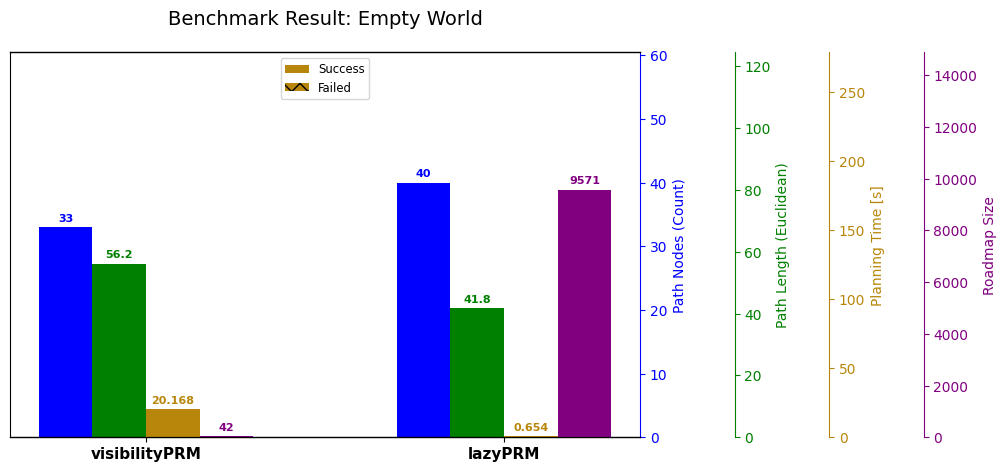

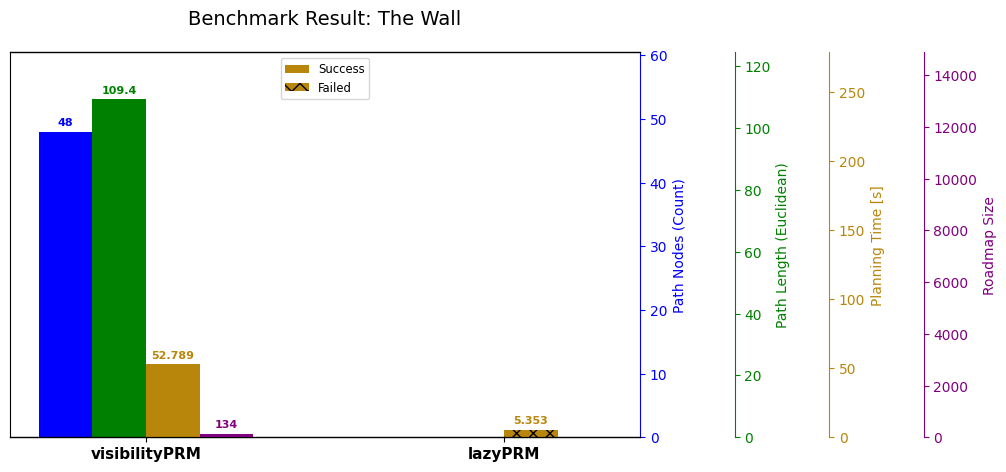

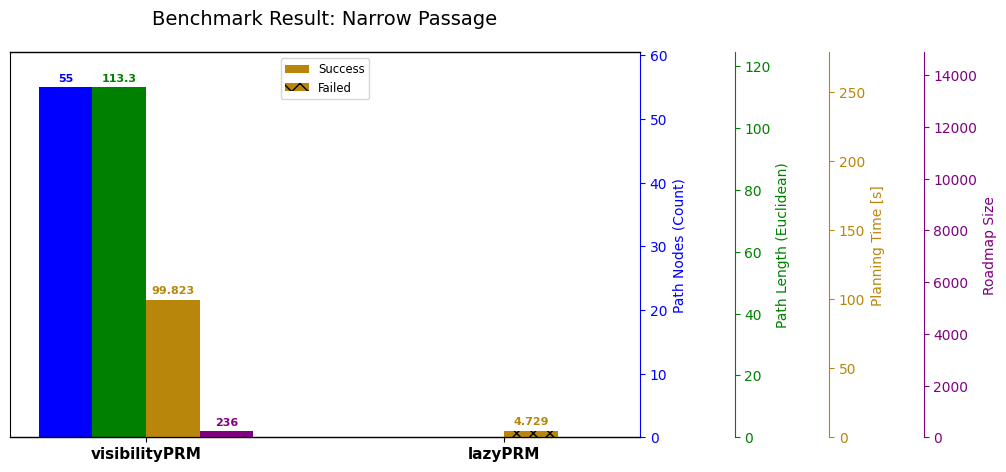

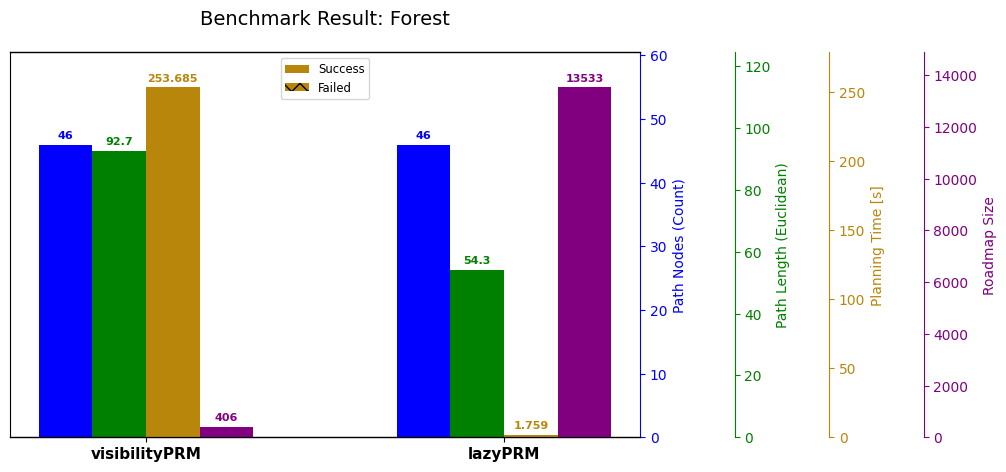

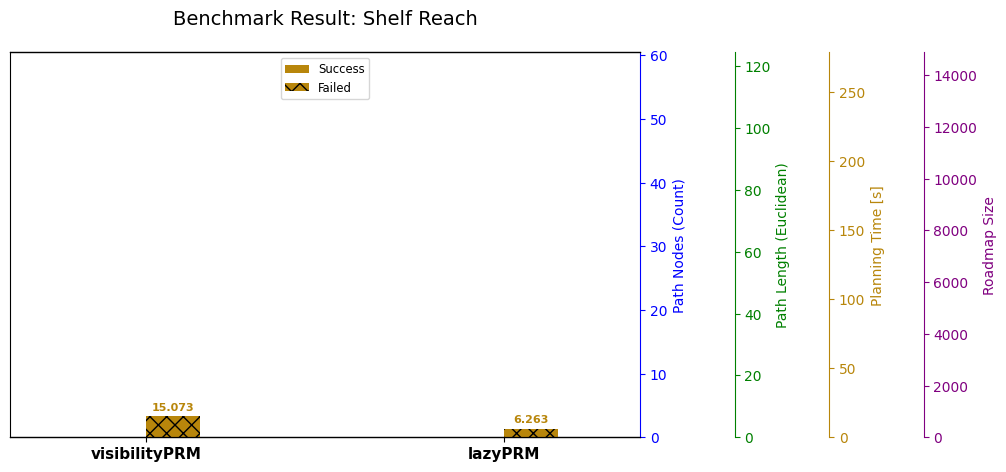

✓ Analysis complete


In [8]:
"""Analyze and visualize single-run benchmark results."""

print("Generating benchmark analysis visualizations...")
BenchmarkPlotter.visualize(
    resultList,
    benchList,
    save_plots=savePlots,
    output_dir=folderPath2save
)
print("✓ Analysis complete")

## 8️⃣ Statistical Batch Evaluation

### Multiple Independent Runs

Executes each planner-benchmark combination multiple times to collect statistical data:
- **Reproducibility**: Fresh planner instance per run (no state leakage)
- **Statistical metrics**: Success rates, mean/std timing, path length distributions
- **Failure analysis**: Tracks which goal segments cause failures
- **Comparative statistics**: Robust performance comparison across algorithms

#### Results DataFrame

The output contains:
- **Planner**: Algorithm name
- **Benchmark**: Scenario identifier
- **RunID**: Sequential run number (0-indexed)
- **Success**: Boolean planning success indicator
- **Time**: Execution time (seconds)
- **PathNodes**: Number of nodes in solution trajectory
- **PathEuclid**: Euclidean distance of path (meters)
- **GraphNodes**: Total nodes in constructed planning graph
- **FailStage**: Failure location or "Success" for successful runs

In [9]:
"""
Execute batch evaluation with multiple independent runs per scenario.

Each planner is instantiated fresh for every run to ensure reproducible,
stateless execution. Collects comprehensive performance statistics.
"""

# --- Configuration ---
NUMBER_OF_RUNS = 2  # Modify to increase statistical sample size

print("\n" + "=" * 70)
print(f"BATCH EVALUATION: {NUMBER_OF_RUNS} runs per scenario")
print("=" * 70 + "\n")

# Execute batch evaluation
df_results = BatchEvaluator.run_experiment(plannerFactory, benchList, num_runs=NUMBER_OF_RUNS)

print("\n" + "=" * 70)
print("Evaluation Complete")
print("=" * 70)

# Display results summary
print(f"\nResults Summary:")
print(f"  Total runs: {len(df_results)}")
print(f"  Successful: {df_results['Success'].sum()}")
print(f"  Failed: {(~df_results['Success']).sum()}")
print(f"  Success rate: {100 * df_results['Success'].mean():.1f}%\n")

# Display first few rows
print("First 5 results:")
display(df_results.head())

# Optional: Save results to CSV for external analysis
# df_results.to_csv(f"benchmark_results_{NUMBER_OF_RUNS}runs.csv", index=False)


BATCH EVALUATION: 2 runs per scenario



Running Batch Evaluation:   0%|          | 0/20 [00:00<?, ?it/s]

visibilityPRM:
    Running Benchmark Empty World 1/2...
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.
        [Action] PICK: Removed static object.
        [Action] PICK: Grasping.
        [Runner] Segment 1: PLACE with offset [0.0, -0.6]. Planning to Standoff.
        [Action] PLACE: Releasing.
        [Action] PLACE: Object becomes obstacle.
        [Runner] Segment 2: MOVE. Planning directly to target.
    Running Benchmark Empty World 2/2...
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.
        [Action] PICK: Removed static object.
        [Action] PICK: Grasping.
        [Runner] Segment 1: PLACE with offset [0.0, -0.6]. Planning to Standoff.
        [Action] PLACE: Releasing.
        [Action] PLACE: Object becomes obstacle.
        [Runner] Segment 2: MOVE. Planning directly to tar

Planner       Benchmark  RunID  Success       Time  PathNodes  \
0  visibilityPRM     Empty World      0     True  20.806905       40.0   
1  visibilityPRM     Empty World      1     True  20.306247       35.0   
2  visibilityPRM        The Wall      0     True  51.778425       40.0   
3  visibilityPRM        The Wall      1     True  57.288874       48.0   
4  visibilityPRM  Narrow Passage      0     True  83.543450       50.0   

   PathEuclid  GraphNodes FailStage  
0   91.439808          57   Success  
1   60.584727          53   Success  
2   76.219101         137   Success  
3   99.765156         135   Success  
4   87.271090         220   Success

Generating batch evaluation visualizations...


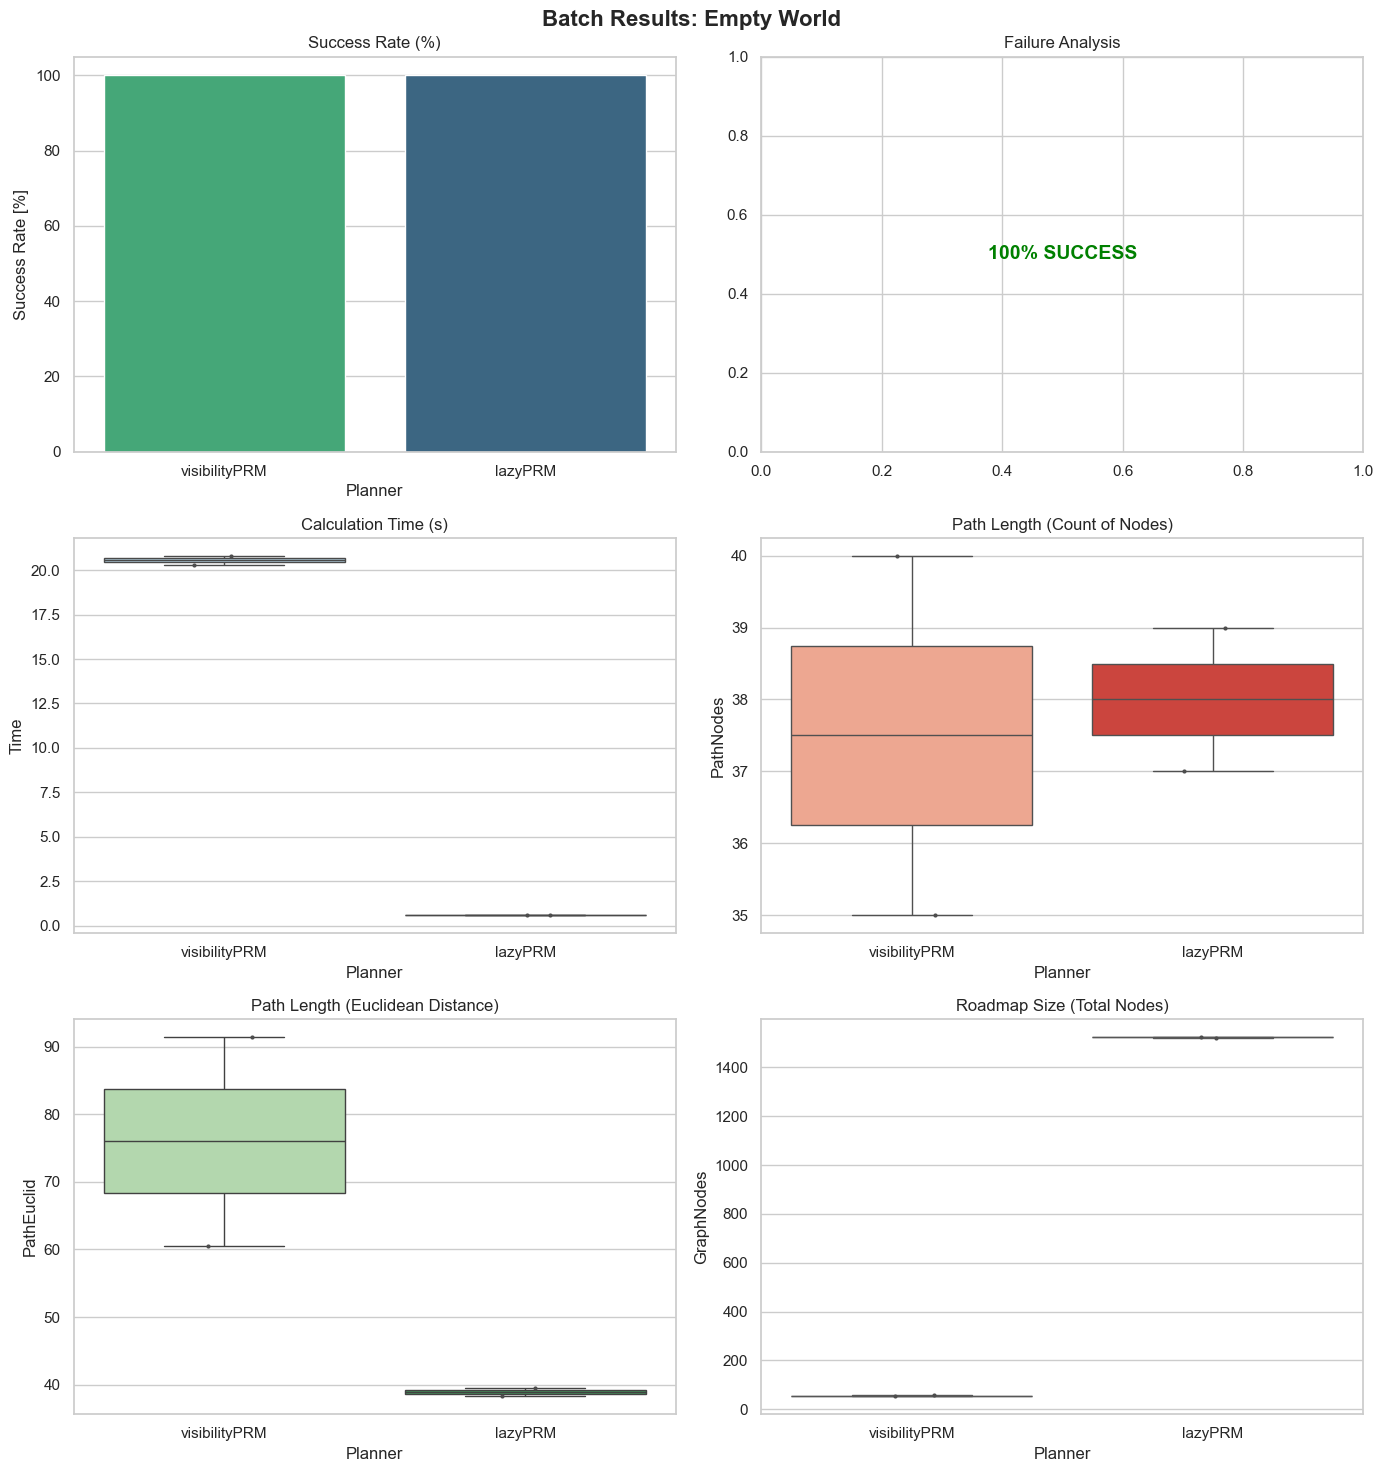

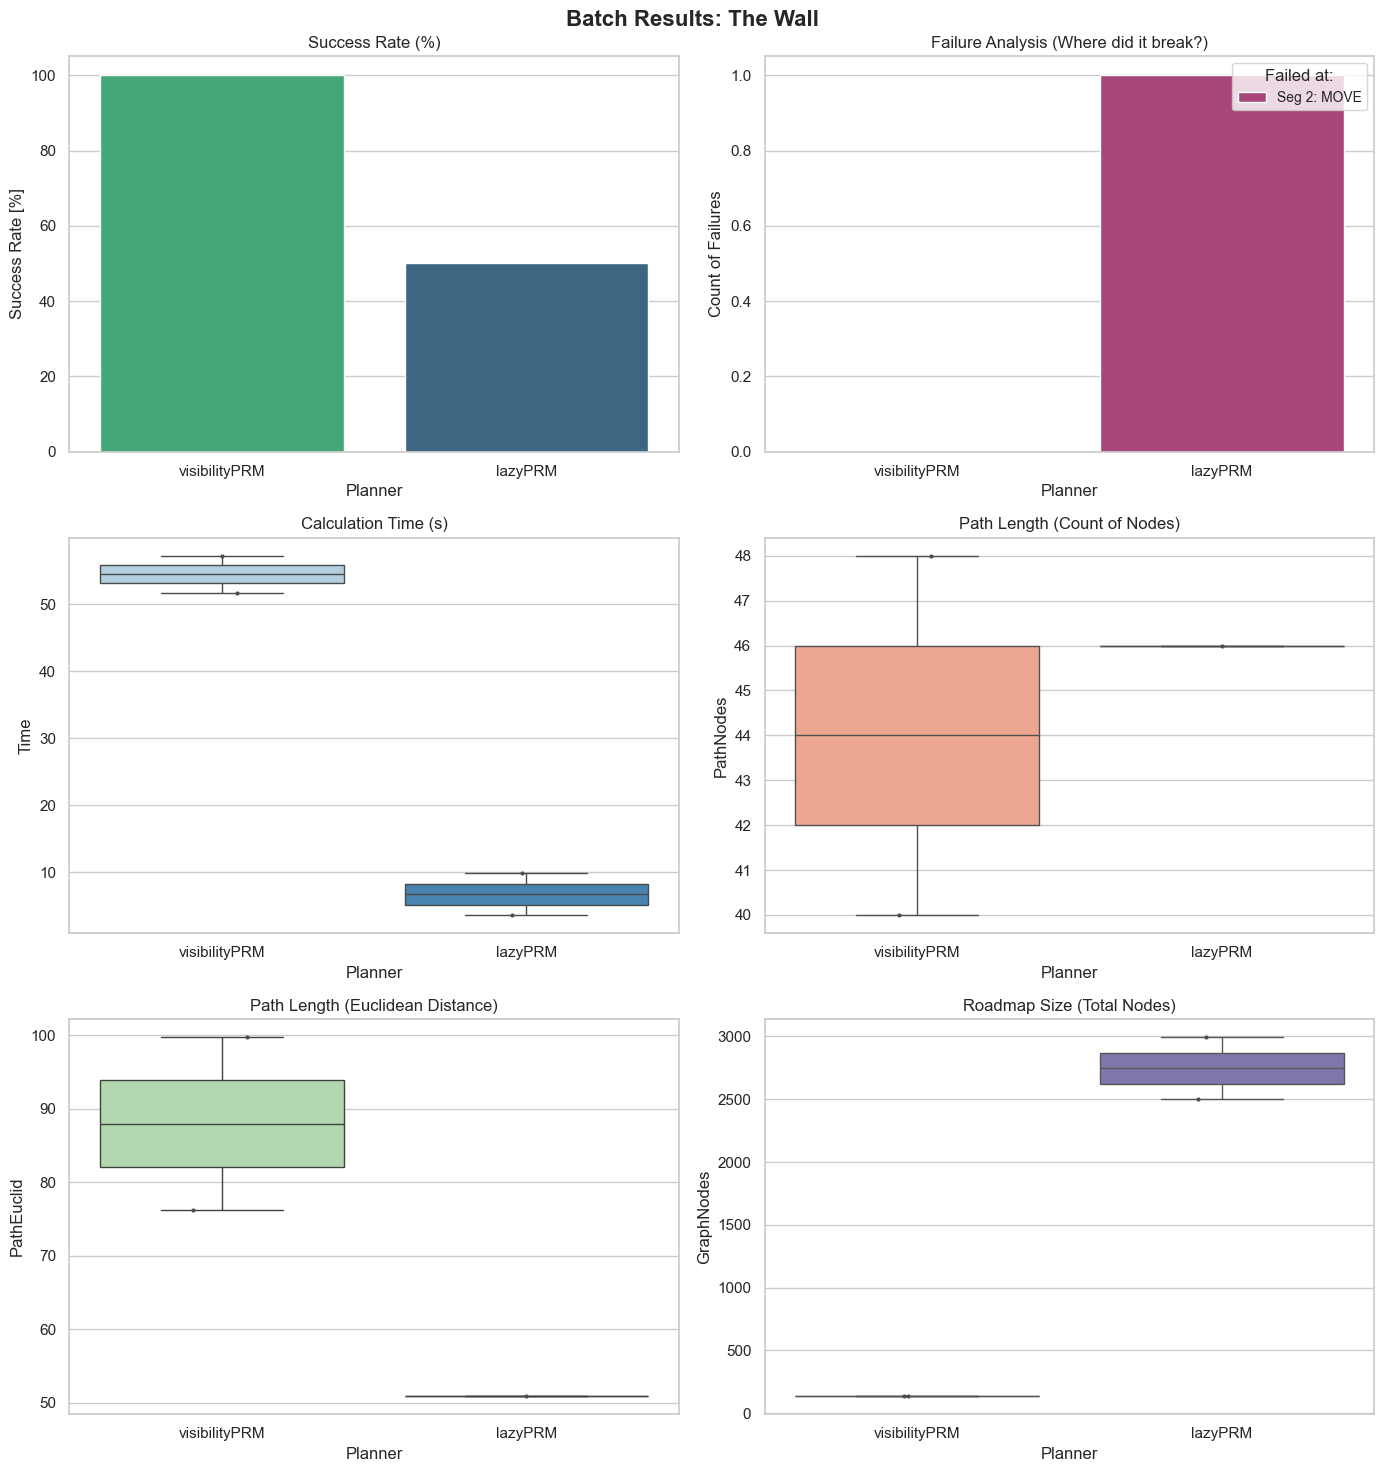

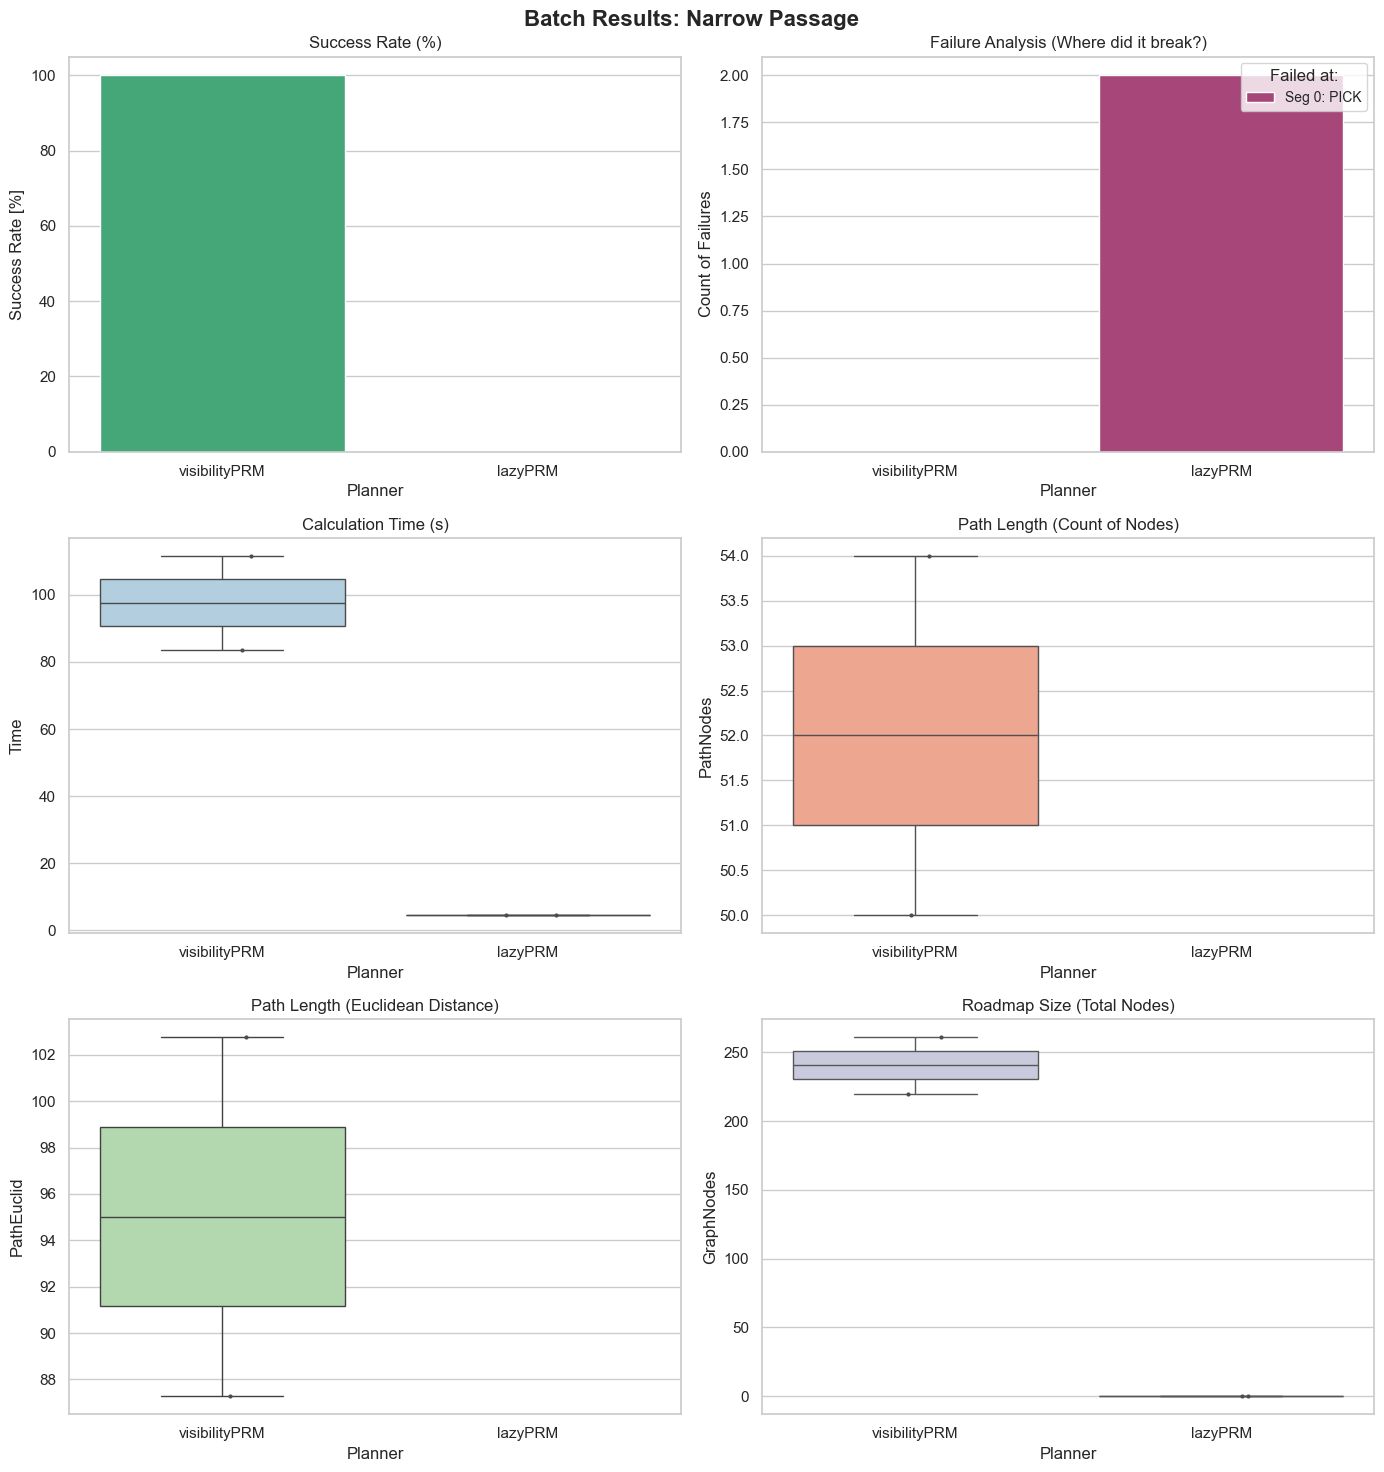

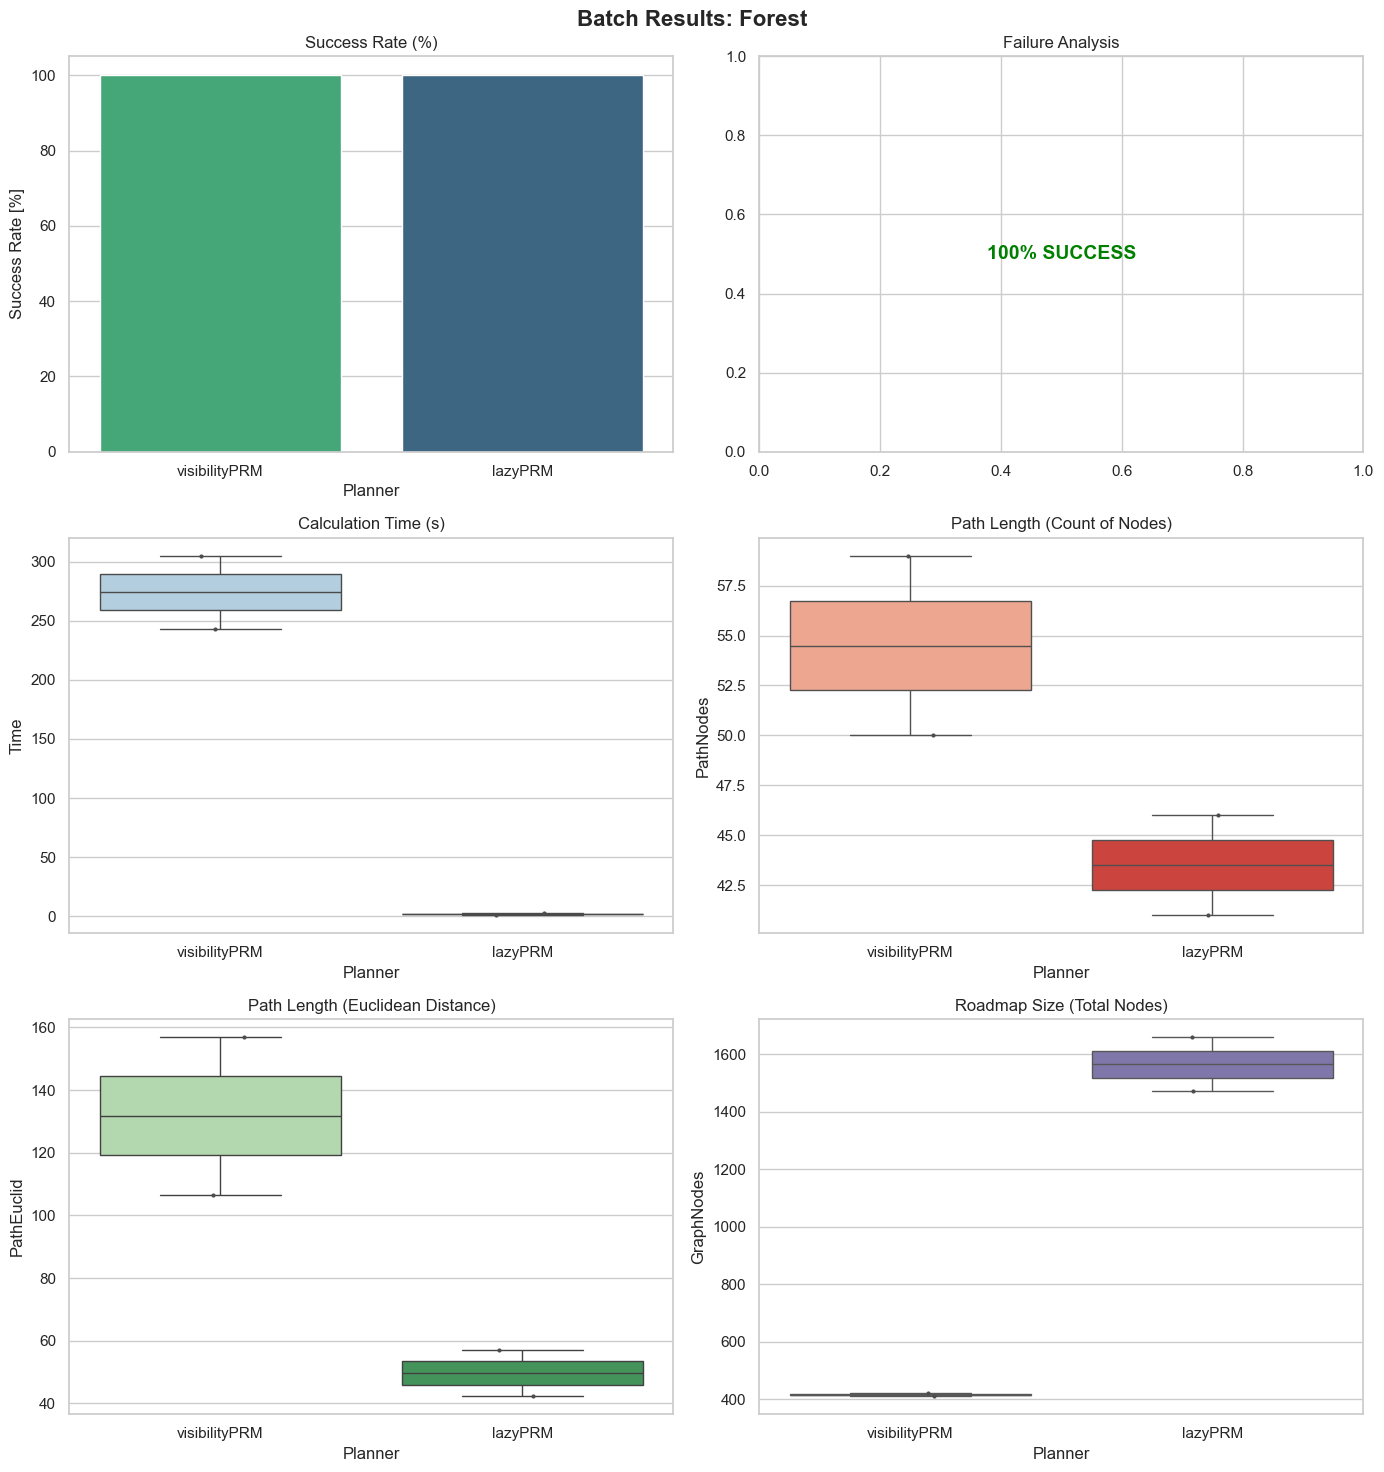

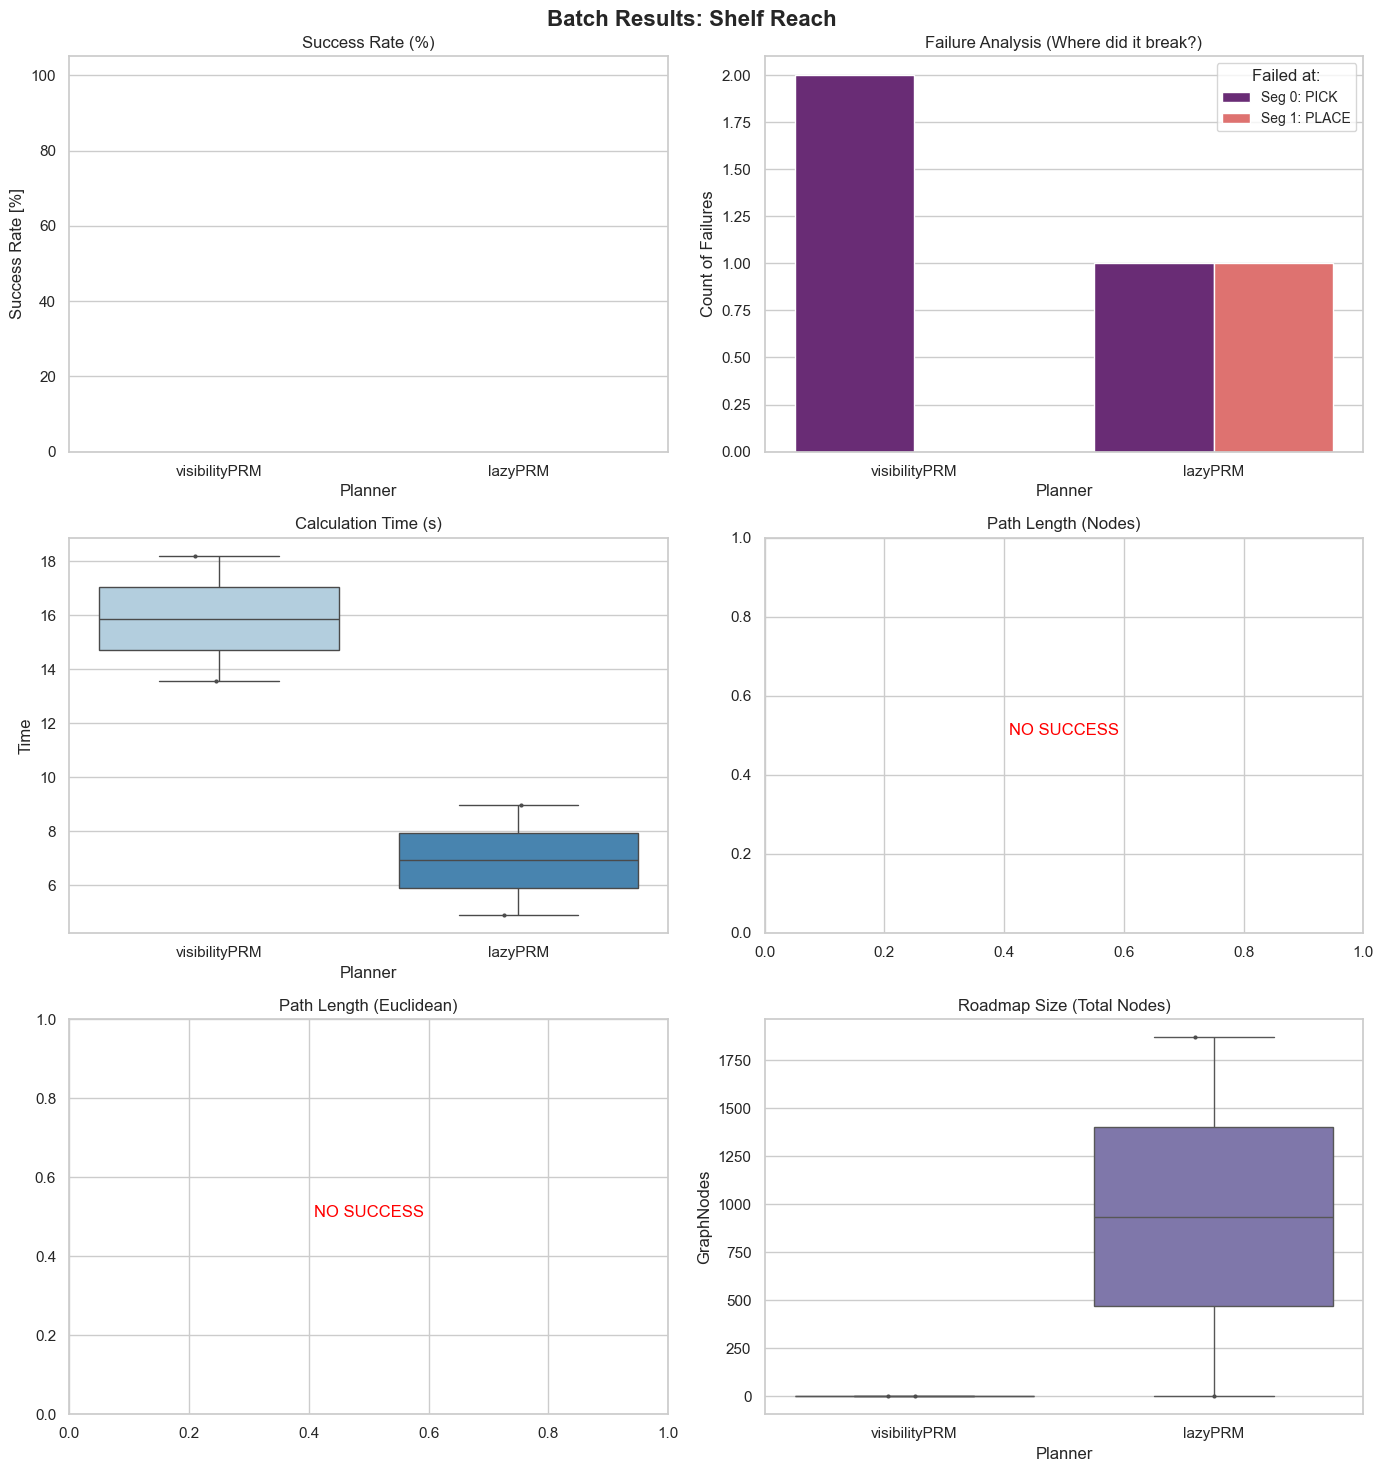

✓ Statistical analysis complete

BATCH RESULTS SUMMARY

VISIBILITYPRM:
  Success rate: 80.0%
  Mean execution time: 111.733s
  Mean path length (Euclidean): 97.70 LE

LAZYPRM:
  Success rate: 50.0%
  Mean execution time: 1.697s
  Mean path length (Euclidean): 45.59 LE



In [11]:
"""Visualize batch evaluation results with statistical analysis."""

print("Generating batch evaluation visualizations...")
BatchPlotter.visualize(
    df_results,
    save_plots=savePlots,
    output_dir=folderPath2save
)
print("✓ Statistical analysis complete")

# Summary statistics
print("\n" + "=" * 70)
print("BATCH RESULTS SUMMARY")
print("=" * 70)
for planner in df_results['Planner'].unique():
    planner_data = df_results[df_results['Planner'] == planner]
    success_rate = 100 * planner_data['Success'].mean()
    mean_time = planner_data[planner_data['Success']]['Time'].mean()
    print(f"\n{planner.upper()}:")
    print(f"  Success rate: {success_rate:.1f}%")
    print(f"  Mean execution time: {mean_time:.3f}s")
    print(f"  Mean path length (Euclidean): {planner_data[planner_data['Success']]['PathEuclid'].mean():.2f} LE")
print("\n" + "=" * 70)